# Fake News Classifier EN

## Import

In [1]:
import re
import time
import joblib

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.DataFrame()
df = df.append(pd.read_csv('american_datasets/cleaned/1.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/2.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/3.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/5.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/6.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/7.csv', index_col=0))
df = df.append(pd.read_csv('american_datasets/cleaned/8.csv', index_col=0))
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text label  
0  WASHINGTON (Reuters) - The head of a conservat...  True  
1  WASHINGTON (Reuters) - Transgender people will...  True  
2  WASHINGTON (Reuters) - The special counsel inv...  True  
3  WASHINGTON (Reuters) - Trump campaign adviser ...  True  
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  True

In [3]:
df.shape

(94349, 3)

## Visualization

(array([40835.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 53514.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

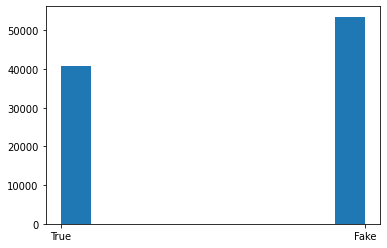

In [4]:
plt.hist(df['label'])

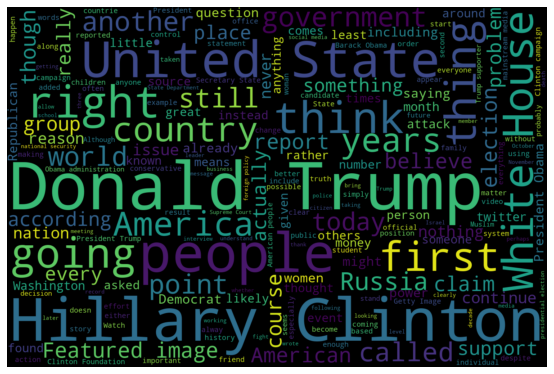

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing


In [6]:
print("Title:\n", df['title'].values[3])
print("Body:\n", df['text'].values[3])

Title:
 FBI Russia probe helped by Australian diplomat tip-off: NYT
Body:
 WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including

### Remove junk

In [7]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  as u s budget fight looms republicans flip the...   
1  u s military to accept transgender recruits on...   
2  senior u s republican senator let mr mueller d...   
3  fbi russia probe helped by australian diplomat...   
4  trump wants postal service to charge much more...   

                                                text label  
0  washington reuters the head of a conservative ...  True  
1  washington reuters transgender people will be ...  True  
2  washington reuters the special counsel investi...  True  
3  washington reuters trump campaign adviser geor...  True  
4  seattle washington reuters president donald tr...  True

In [8]:
print("Title:\n", df['title'].values[3])
print("Body:\n", df['text'].values[3])

Title:
 fbi russia probe helped by australian diplomat tip off nyt
Body:
 washington reuters trump campaign adviser george papadopoulos told an australian diplomat in may that russia had political dirt on democratic presidential candidate hillary clinton the new york times reported on saturday the conversation between papadopoulos and the diplomat alexander downer in london was a driving factor behind the fbi s decision to open a counter intelligence investigation of moscow s contacts with the trump campaign the times reported two months after the meeting australian officials passed the information that came from papadopoulos to their american counterparts when leaked democratic emails began appearing online according to the newspaper which cited four current and former u s and foreign officials besides the information from the australians the probe by the federal bureau of investigation was also propelled by intelligence from other friendly governments including the british and dutch 

### Remove stop words

In [9]:
stop_words = set(stopwords.words("english"))

def remove_stop_words(text):
  res = []
  for word in text.split():
      if word not in stop_words:
          res.append(word)
  return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0  u budget fight looms republicans flip fiscal s...   
1  u military accept transgender recruits monday ...   
2     senior u republican senator let mr mueller job   
3  fbi russia probe helped australian diplomat ti...   
4  trump wants postal service charge much amazon ...   

                                                text label  
0  washington reuters head conservative republica...  True  
1  washington reuters transgender people allowed ...  True  
2  washington reuters special counsel investigati...  True  
3  washington reuters trump campaign adviser geor...  True  
4  seattle washington reuters president donald tr...  True

In [10]:
print("Title:\n", df['title'].values[3])
print("Body:\n", df['text'].values[3])

Title:
 fbi russia probe helped australian diplomat tip nyt
Body:
 washington reuters trump campaign adviser george papadopoulos told australian diplomat may russia political dirt democratic presidential candidate hillary clinton new york times reported saturday conversation papadopoulos diplomat alexander downer london driving factor behind fbi decision open counter intelligence investigation moscow contacts trump campaign times reported two months meeting australian officials passed information came papadopoulos american counterparts leaked democratic emails began appearing online according newspaper cited four current former u foreign officials besides information australians probe federal bureau investigation also propelled intelligence friendly governments including british dutch times said papadopoulos chicago based international energy lawyer pleaded guilty oct lying fbi agents contacts people claimed ties top russian officials first criminal charge alleging links trump campaign

## Stemming

In [11]:
snowball_stemmer = SnowballStemmer(language='english')

def stemmer(text):
  res = []
  for word in text.split():
      res.append(snowball_stemmer.stem(word))
  return " ".join(res)

df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0  u budget fight loom republican flip fiscal script   
1  u militari accept transgend recruit monday pen...   
2       senior u republican senat let mr mueller job   
3  fbi russia probe help australian diplomat tip nyt   
4  trump want postal servic charg much amazon shi...   

                                                text label  
0  washington reuter head conserv republican fact...  True  
1  washington reuter transgend peopl allow first ...  True  
2  washington reuter special counsel investig lin...  True  
3  washington reuter trump campaign advis georg p...  True  
4  seattl washington reuter presid donald trump c...  True

In [12]:
print("Title:\n", df['title'].values[3])
print("Body:\n", df['text'].values[3])

Title:
 fbi russia probe help australian diplomat tip nyt
Body:
 washington reuter trump campaign advis georg papadopoulo told australian diplomat may russia polit dirt democrat presidenti candid hillari clinton new york time report saturday convers papadopoulo diplomat alexand downer london drive factor behind fbi decis open counter intellig investig moscow contact trump campaign time report two month meet australian offici pass inform came papadopoulo american counterpart leak democrat email began appear onlin accord newspap cite four current former u foreign offici besid inform australian probe feder bureau investig also propel intellig friend govern includ british dutch time said papadopoulo chicago base intern energi lawyer plead guilti oct lie fbi agent contact peopl claim tie top russian offici first crimin charg alleg link trump campaign russia white hous play former aid campaign role say extrem limit action took would new york time howev report papadopoulo help set meet candid

## ML Model

In [13]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [14]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1,2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
models = list()
for classifier in classifiers:
    start_time = time.time()

    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    training_time = time.time() - start_time
    print_metrics(y_test, y_pred, training_time)
    models.append(model)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 194 s
1. Accuracy: 0.9311
2. Precision: 0.9354


3. Recall: 0.9254
4. F1 score: 0.9292
5. Confusion Matrix

 Predicted   Fake   True
Actual                 
Fake       15483    484
True        1467  10871
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 72 s
1. Accuracy: 0.9407
2. Precision: 0.9422


3. Recall: 0.9373
4. F1 score: 0.9394
5. Confusion Matrix

 Predicted   Fake   True
Actual                 
Fake       15388    579
True        1099  11239
---------------------------------
DecisionTreeClassifier()


0. Training time: 448 s
1. Accuracy: 0.9225
2. Precision: 0.9238


3. Recall: 0.9184
4. F1 score: 0.9207
5. Confusion Matrix

 Predicted   Fake   True
Actual                 
Fake       15168    799
True        1396  10942
---------------------------------
AdaBoostClassifier()


0. Training time: 207 s
1. Accuracy: 0.9157
2. Precision: 0.9166


3. Recall: 0.9117
4. F1 score: 0.9138
5. Confusion Matrix

 Predicted   Fake   True
Actual                 
Fake       15046    921
True        1466  10872
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 92 s
1. Accuracy: 0.5835
2. Precision: 0.7823


3. Recall: 0.5223
4. F1 score: 0.4081
5. Confusion Matrix

 Predicted   Fake  True
Actual                
Fake       15961     6
True       11784   554


In [16]:
joblib.dump(models[0], open('american_models/random_forest.joblib', 'wb'))
joblib.dump(models[1], open('american_models/logistic_regression.joblib', 'wb'))
joblib.dump(models[2], open('american_models/decision_tree.joblib', 'wb'))
joblib.dump(models[3], open('american_models/ada_boost.joblib', 'wb'))
joblib.dump(models[4], open('american_models/knn.joblib', 'wb'))